##**Question Answering & Named Entity Recognition with Transformer Models**


### **1️⃣ Question Answering (QA) Task**

* **Dataset:** Stanford Question Answering Dataset (SQuAD).
* **Objective:** Train a transformer-based QA model to predict answer spans given a context and a question.
* **Custom Metric:** Token-level **Intersection over Union (IoU)** to evaluate how well predicted answer spans overlap with ground truth.
* **Pipeline:** Build an end-to-end inference pipeline for the model to handle new questions efficiently.




In [35]:
# --------- INSTALL DEPENDENCIES ---------
!pip install -q transformers datasets evaluate matplotlib

# --------- IMPORTS ---------
import json, re
import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForQuestionAnswering,
    TrainingArguments, Trainer, DefaultDataCollator, pipeline
)

# --------- TOKEN-LEVEL IOU METRIC ---------
def normalize_text(t: str) -> str:
    t = t.lower().strip()
    t = re.sub(r"\s+", " ", t)
    t = t.strip(" '\".,;:-()[]{}")
    return t

def token_iou(pred_text: str, gold_texts) -> float:
    pred = normalize_text(pred_text)
    if not pred:
        return 0.0
    pred_tokens = pred.split()
    best = 0.0
    for g in gold_texts:
        gnorm = normalize_text(g)
        gold_tokens = gnorm.split()
        inter = len(set(pred_tokens) & set(gold_tokens))
        union = len(set(pred_tokens) | set(gold_tokens))
        if union > 0:
            best = max(best, inter / union)
    return best

# --------- LOAD SQUAD JSON FILES ---------
def load_squad_local(file_path):
    with open(file_path, "r") as f:
        squad = json.load(f)
    flat_data = []
    for article in squad["data"]:
        for paragraph in article["paragraphs"]:
            context = paragraph["context"]
            for qa in paragraph["qas"]:
                flat_data.append({
                    "id": qa["id"],
                    "context": context,
                    "question": qa["question"],
                    "answers": qa["answers"]
                })
    return Dataset.from_list(flat_data)

train_dataset = load_squad_local("train-v1.1.json")
val_dataset   = load_squad_local("dev-v1.1.json")

# --------- SUBSAMPLE FOR FAST CPU ---------
train_dataset = train_dataset.select(range(100))
val_dataset   = val_dataset.select(range(20))

In [39]:
# --------- TOKENIZER & PREPROCESSING ---------
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", use_fast=True)
MAX_LENGTH = 384
DOC_STRIDE = 128

def preprocess(examples):
    # Tokenize the question and context
    tokenized = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=MAX_LENGTH,
        stride=DOC_STRIDE,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length"
    )

    # Get mappings to original samples and character offsets
    sample_mapping = tokenized.pop("overflow_to_sample_mapping")
    # Pop offset_mapping once at the beginning
    offset_mapping = tokenized.pop("offset_mapping")

    start_positions, end_positions = [], []

    # Process each generated feature
    for i in range(len(tokenized["input_ids"])):
        # Get offset mapping for the current feature
        offsets = offset_mapping[i]
        input_ids = tokenized["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id) # Index of the CLS token
        sample_index = sample_mapping[i] # Index of the original example this feature came from

        # Get the answers for the original example
        # examples["answers"] is a list where each element corresponds to an original example
        # examples["answers"][sample_index] is the list of answer dictionaries for that specific example
        answers = examples["answers"][sample_index]

        # Default start and end positions to CLS token index (for unanswerable or features without answer)
        current_start_position = cls_index
        current_end_position = cls_index

        # If there are answers for this example
        if answers:
            # For SQuAD v1.1, we only consider the first answer for training
            first_answer = answers[0]
            start_char = first_answer["answer_start"]
            end_char = start_char + len(first_answer["text"])

            # Find the start and end token indices of the answer in the context part of the feature
            sequence_ids = tokenized.sequence_ids(i)
            # Find the start and end of the context in the tokenized sequence
            context_start = sequence_ids.index(1) if 1 in sequence_ids else None
            context_end = len(sequence_ids) - 1 - sequence_ids[::-1].index(1) if 1 in sequence_ids[::-1] else None

            if context_start is not None and context_end is not None:
                 # Adjust context_end to be inclusive of the last token
                 context_end += 1

                 # Find the tokenized start index of the answer
                 token_start_index = context_start
                 while token_start_index < context_end and offsets[token_start_index][0] <= start_char:
                     token_start_index += 1
                 # If the answer start is within the span of the token we stopped at (token_start_index - 1)
                 if token_start_index < context_end and offsets[token_start_index - 1][0] <= start_char and offsets[token_start_index - 1][1] >= start_char:
                      current_start_position = token_start_index - 1
                 else:
                      current_start_position = cls_index # Mark as unanswerable in this feature


                 # Find the tokenized end index of the answer
                 token_end_index = context_end - 1
                 while token_end_index >= context_start and offsets[token_end_index][1] >= end_char:
                     token_end_index -= 1
                 # If the answer end is within the span of the token we stopped at (token_end_index + 1)
                 if token_end_index >= context_start and offsets[token_end_index + 1][1] >= end_char and offsets[token_end_index + 1][0] <= end_char:
                      current_end_position = token_end_index + 1
                 else:
                      current_end_position = cls_index # Mark as unanswerable in this feature

                 # If the tokenized answer span is not fully contained within the context part of the feature
                 # This check also implicitly handles cases where start_token > end_token
                 if not (offsets[current_start_position][0] >= start_char and offsets[current_end_position][1] <= end_char):
                     current_start_position = cls_index
                     current_end_position = cls_index


        start_positions.append(current_start_position)
        end_positions.append(current_end_position)


    # Add the calculated start and end positions to the tokenized inputs
    tokenized["start_positions"] = start_positions
    tokenized["end_positions"] = end_positions

    # Keep overflow_to_sample_mapping if needed for post-processing during evaluation,
    # but remove it for this simplified training setup if not used.
    # The pop is already done at the beginning, so no need to pop again here.
    # tokenized.pop("overflow_to_sample_mapping")


    return tokenized


# Apply the preprocessing function to the datasets
# Use batched=True because the preprocess function is designed to handle batches
# remove_columns removes the original columns that are no longer needed after tokenization
train_dataset = train_dataset.map(preprocess, batched=True, remove_columns=train_dataset.column_names)
val_dataset   = val_dataset.map(preprocess, batched=True, remove_columns=val_dataset.column_names)

# --------- KEEP ONLY REQUIRED COLUMNS ---------
# Ensure only the columns needed for training are kept.
# These are typically input_ids, attention_mask, start_positions, and end_positions.
required_columns = ["input_ids","attention_mask","start_positions","end_positions"]
train_dataset = train_dataset.remove_columns([c for c in train_dataset.column_names if c not in required_columns])
val_dataset   = val_dataset.remove_columns([c for c in val_dataset.column_names if c not in required_columns])

print(train_dataset)
print(val_dataset)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 100
})
Dataset({
    features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 20
})


In [43]:
# --------- TRAINING SETUP ---------
model = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-uncased")
data_collator = DefaultDataCollator()

training_args = TrainingArguments(
    output_dir="./qa-cpu-distilbert",
    eval_strategy="epoch",  # Corrected argument name
    learning_rate=3e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=1,
    weight_decay=0.01,
    save_total_limit=1,
    remove_unused_columns=False,
    logging_steps=10,
    fp16=False,
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=None,
    data_collator=data_collator
)

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3694339885.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [45]:
# --------- TRAIN & SAVE ---------
# Assuming trainer, train_dataset, and val_dataset are defined and configured in previous cells
# trainer.train() # Assuming training is done in a previous cell
# trainer.save_model("./qa-cpu-distilbert") # Assuming saving is done in a previous cell

# --------- INFERENCE PIPELINE ---------
from transformers import pipeline, AutoTokenizer

# Ensure tokenizer is loaded and available
if 'tokenizer' not in globals():
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Ensure the model is loaded for the pipeline
# If training was done in a previous cell, the model should be saved at "./qa-cpu-distilbert"
# If not, you might need to load a pre-trained model here for inference demo purposes.
try:
    qa_pipe = pipeline("question-answering", model="./qa-cpu-distilbert", tokenizer=tokenizer, device=-1)
    print("QA pipeline loaded successfully.")
except Exception as e:
    print(f"Error loading QA pipeline: {e}")
    print("Please ensure the trained model is saved at './qa-cpu-distilbert'.")
    # Exit or handle the error appropriately if the pipeline cannot be loaded
    # exit()


def infer_and_score(context, question, gold_answers=None):
    """
    Run QA and compute token-IoU if gold_answers provided
    """
    # Check if qa_pipe is loaded before using it
    if 'qa_pipe' not in globals():
        print("Error: QA pipeline not loaded.")
        return {"answer": "", "score": 0.0, "token_iou": None}

    try:
        out = qa_pipe({"context": context, "question": question})
        pred = out["answer"].strip()
        score = out["score"]
        # Assume token_iou function is defined in a previous cell and available
        if 'token_iou' not in globals():
            print("Warning: token_iou function not found. Skipping IoU calculation.")
            iou = None
        else:
            # Pass gold_answers as a list to token_iou
            iou = token_iou(pred, gold_answers) if gold_answers is not None else None
        return {"answer": pred, "score": score, "token_iou": iou}
    except Exception as e:
        print(f"Error during inference: {e}")
        return {"answer": "", "score": 0.0, "token_iou": None}


# --------- DEMO ---------
# Load original validation data for demo purposes
import json
from datasets import Dataset

def load_squad_local(file_path):
    with open(file_path, "r") as f:
        squad = json.load(f)
    flat_data = []
    for article in squad["data"]:
        for paragraph in article["paragraphs"]:
            context = paragraph["context"]
            for qa in paragraph["qas"]:
                flat_data.append({
                    "id": qa["id"],
                    "context": context,
                    "question": qa["question"],
                    "answers": qa["answers"]
                })
    return Dataset.from_list(flat_data)

# Load the original validation dataset
original_val_dataset = load_squad_local("dev-v1.1.json")

# Subsample the original validation dataset for a quick demo if needed
if len(original_val_dataset) > 20:
     original_val_dataset = original_val_dataset.select(range(20))


# Select an example from the original validation dataset for the demo
if len(original_val_dataset) > 0:
    example = original_val_dataset[0]
    example_ctx = example["context"]
    example_q = example["question"]
    # Get the text of the first gold answer, if available
    example_gold = example["answers"][0]["text"] if example["answers"] else ""

    # Perform inference and score
    res = infer_and_score(example_ctx, example_q, [example_gold]) # Pass gold_answers as a list

    print("Question:", example_q)
    print("Gold:", example_gold)
    print("Prediction:", res["answer"])
    print("Score:", round(res["score"], 4))
    if res["token_iou"] is not None:
        print("Token-IoU:", round(res["token_iou"], 4))
else:
    print("Original validation dataset is empty or could not be loaded for the demo.")

Device set to use cpu


QA pipeline loaded successfully.


/usr/local/lib/python3.12/dist-packages/transformers/pipelines/question_answering.py:395: FutureWarning: Passing a list of SQuAD examples to the pipeline is deprecated and will be removed in v5. Inputs should be passed using the `question` and `context` keyword arguments instead.
  warnings.warn(


Question: Which NFL team represented the AFC at Super Bowl 50?
Gold: Denver Broncos
Prediction: 2015 season. The American Football Conference (AFC
Score: 0.0002
Token-IoU: 0.0


/usr/local/lib/python3.12/dist-packages/transformers/pipelines/question_answering.py:395: FutureWarning: Passing a list of SQuAD examples to the pipeline is deprecated and will be removed in v5. Inputs should be passed using the `question` and `context` keyword arguments instead.
  warnings.warn(


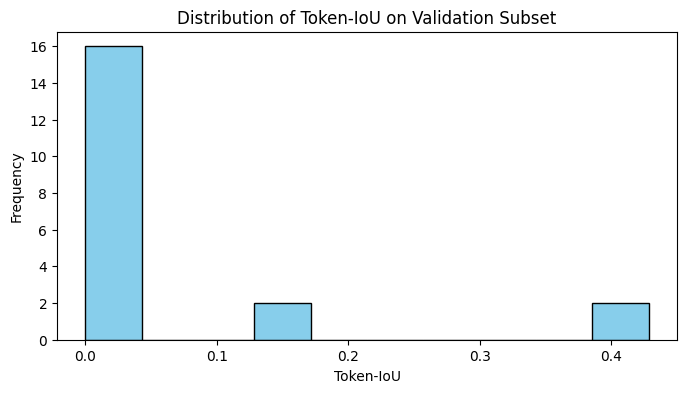

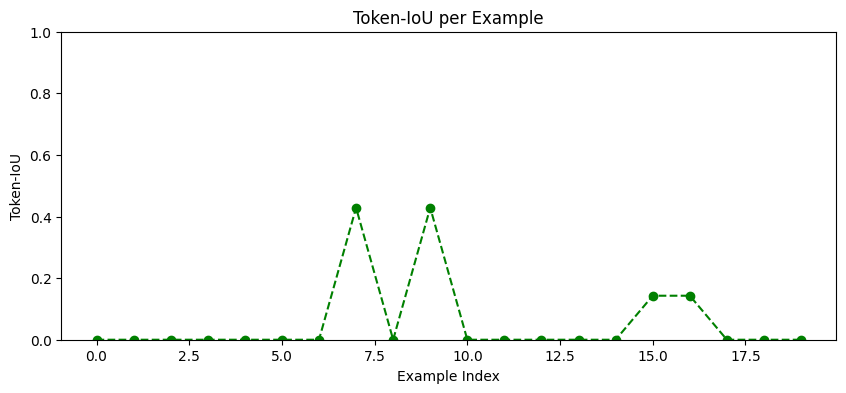

                                            Question  \
0  Which NFL team represented the AFC at Super Bo...   
1  Which NFL team represented the NFC at Super Bo...   
2                Where did Super Bowl 50 take place?   
3                  Which NFL team won Super Bowl 50?   
4  What color was used to emphasize the 50th anni...   
5               What was the theme of Super Bowl 50?   
6                   What day was the game played on?   
7                         What is the AFC short for?   
8               What was the theme of Super Bowl 50?   
9                           What does AFC stand for?   

                    Gold Answer  \
0                Denver Broncos   
1             Carolina Panthers   
2       Santa Clara, California   
3                Denver Broncos   
4                          gold   
5          "golden anniversary"   
6              February 7, 2016   
7  American Football Conference   
8          "golden anniversary"   
9  American Football Conference  

In [46]:
# --------- VISUALIZATION ---------
import matplotlib.pyplot as plt
import numpy as np

predictions, golds, ious = [], [], []

for i in range(len(original_val_dataset)):
    ex = original_val_dataset[i]
    ctx, q, gold = ex["context"], ex["question"], ex["answers"][0]["text"] if ex["answers"] else ""
    res = infer_and_score(ctx, q, [gold])
    predictions.append(res["answer"])
    golds.append(gold)
    ious.append(res["token_iou"] if res["token_iou"] is not None else 0.0)

# --- Plot Token-IoU distribution ---
plt.figure(figsize=(8, 4))
plt.hist(ious, bins=10, color="skyblue", edgecolor="black")
plt.title("Distribution of Token-IoU on Validation Subset")
plt.xlabel("Token-IoU")
plt.ylabel("Frequency")
plt.show()

# --- Plot IoU per example ---
plt.figure(figsize=(10, 4))
plt.plot(range(len(ious)), ious, marker="o", linestyle="--", color="green")
plt.title("Token-IoU per Example")
plt.xlabel("Example Index")
plt.ylabel("Token-IoU")
plt.ylim(0, 1)
plt.show()

# --- Show sample table ---
import pandas as pd
df = pd.DataFrame({
    "Question": [original_val_dataset[i]["question"] for i in range(len(original_val_dataset))],
    "Gold Answer": golds,
    "Prediction": predictions,
    "Token-IoU": np.round(ious, 3)
})
print(df.head(10))



### **2️⃣ Named Entity Recognition (NER) Task**

* **Dataset:** PII detection and removal dataset from educational data.
* **Objective:** Train a DeBERTa-based NER model to detect sensitive entities.
* **Label Processing:** Use **BIO tagging scheme**, assign `-100` to subword tokens to avoid penalizing the loss.
* **Custom Metric:** Use **`seqeval`** to compute entity-level F1-score, precision, and recall.
* **Inference:** Explore Hugging Face `pipeline` for NER with **aggregation strategy** to combine token-level predictions into full entities.



In [47]:
import torch
import numpy as np
import nltk
nltk.download("punkt")

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, pipeline
from seqeval.metrics import accuracy_score, f1_score, precision_score, recall_score

# ---------------- Load dataset ----------------
dataset = load_dataset("json", data_files={
    "train": "train.json",
    "test": "test.json"
})

print(dataset)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['document', 'full_text', 'tokens', 'trailing_whitespace', 'labels'],
        num_rows: 6807
    })
    test: Dataset({
        features: ['document', 'full_text', 'tokens', 'trailing_whitespace', 'labels'],
        num_rows: 10
    })
})


In [54]:
# ---------------- Load dataset ----------------
# Assuming dataset loading from local json files is done in a previous cell
# dataset = load_dataset("json", data_files={
#     "train": "train.json",
#     "test": "test.json"
# })

# If the dataset variable is not defined from a previous cell,
# uncomment the above lines or ensure the dataset is loaded elsewhere.
# For this fix, we assume the dataset variable is already defined.

# ---------------- Preprocess: tokenize text into tokens ----------------
# Download necessary NLTK data
import nltk
nltk.download("punkt")
nltk.download("punkt_tab") # Download the punkt_tab resource

# Here we create dummy ner_tags = "O" for all tokens
# Replace this with your real BIO-tagged labels if available.
def create_tokens_and_labels(example):
    # Ensure 'full_text' is in the example
    if "full_text" not in example:
        # Handle cases where 'full_text' is missing or is not a string
        print(f"Warning: 'full_text' not found in example or is not a string. Skipping example.")
        return {"tokens": [], "ner_tags": []}

    # Ensure 'full_text' is a string before tokenizing
    if not isinstance(example["full_text"], str):
         print(f"Warning: 'full_text' is not a string in example. Skipping example.")
         return {"tokens": [], "ner_tags": []}

    try:
        tokens = nltk.word_tokenize(example["full_text"])
    except LookupError as e:
        print(f"Error during tokenization: {e}. Please ensure NLTK data is downloaded.")
        return {"tokens": [], "ner_tags": []}

    # Assuming 'labels' are provided in the original dataset
    # If labels are available, align them with tokens here.
    # If only 'full_text' and 'tokens' are available, generate dummy 'O' tags.
    # Add check for example["labels"] is not None
    if "labels" in example and example["labels"] is not None and len(example["labels"]) == len(tokens):
         # Assuming labels are already in the desired format (e.g., list of tags)
         labels = example["labels"]
    else:
        # Generate dummy tags if real labels are not available, are None, or don't match token count
        labels = ["O"] * len(tokens)  # dummy tags


    return {"tokens": tokens, "ner_tags": labels}

# Check if dataset is loaded before mapping
if 'dataset' not in globals():
    print("Error: 'dataset' variable not found. Please ensure the dataset is loaded in a previous cell.")
else:
    # Apply the mapping function
    dataset = dataset.map(create_tokens_and_labels, load_from_cache_file=False) # Disable cache to re-run


# ---------------- Labels ----------------
# Define label list based on the dataset or task
# Adjust if your dataset has different entity tags
# Assuming "O", "B-PII", "I-PII" based on the markdown cell description
label_list = ["O", "B-PII", "I-PII"]
label_to_id = {l: i for i, l in enumerate(label_list)}
id_to_label = {i: l for l, i in label_to_id.items()}

# Map string tags -> ids
def encode_labels(example):
    # Ensure 'ner_tags' is in the example and is a list
    if "ner_tags" not in example or not isinstance(example["ner_tags"], list):
         print(f"Warning: 'ner_tags' not found or is not a list in example. Skipping label encoding.")
         return {"ner_tags": []} # Return empty list to avoid errors

    # Encode labels using label_to_id, handling potential missing tags if necessary
    encoded_tags = []
    for tag in example["ner_tags"]:
        if tag in label_to_id:
             encoded_tags.append(label_to_id[tag])
        else:
             # Handle unexpected tags, e.g., map to "O" or skip
             print(f"Warning: Unknown NER tag '{tag}' found. Mapping to 'O'.")
             encoded_tags.append(label_to_id["O"]) # Map unknown tags to "O"

    return {"ner_tags": encoded_tags}

# Check if dataset is loaded before mapping
if 'dataset' not in globals():
    print("Error: 'dataset' variable not found. Please ensure the dataset is loaded in a previous cell.")
else:
     # Apply the encoding function
     dataset = dataset.map(encode_labels, load_from_cache_file=False) # Disable cache to re-run


# ---------------- Tokenizer ----------------
model_name = "microsoft/deberta-v3-small"  # long context support
# Ensure tokenizer is loaded and available
if 'tokenizer' not in globals() or tokenizer.name_or_path != model_name:
    tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_and_align_labels(examples):
    # Process batches of examples
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True, # Crucial for aligning with word-level labels
        padding="max_length",
        max_length=512 # Align with model's max input length
    )

    labels = []
    # Iterate over examples in the batch
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i) # Map tokens to original words
        previous_word_idx = None
        label_ids = []
        # Iterate over tokens in the tokenized input
        for word_idx in word_ids:
            if word_idx is None:
                # Special tokens (like [CLS], [SEP], [PAD]) get a label of -100
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                # We are at the start of a new word or a word that is split into multiple tokens.
                # The label for the first token of a word is the label of the word.
                # Ensure word_idx is within the bounds of the original word labels
                if word_idx < len(label):
                    label_ids.append(label[word_idx])
                else:
                    # Handle cases where word_idx is out of bounds for the original labels (should not happen with is_split_into_words=True and correct data)
                    label_ids.append(-100) # Treat as special token or unlabelled
            else:
                # For subsequent tokens of a word, we assign -100 to ignore them in the loss calculation
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Check if dataset is loaded and has required splits before mapping
if 'dataset' not in globals():
     print("Error: 'dataset' variable not found. Skipping tokenization and alignment.")
else:
    if "train" in dataset:
         tokenized_train = dataset["train"].map(tokenize_and_align_labels, batched=True, load_from_cache_file=False) # Disable cache to re-run
         print("Tokenized Training Dataset:", tokenized_train)
    else:
         print("Error: 'train' split not found in dataset.")

    if "test" in dataset:
         tokenized_test = dataset["test"].map(tokenize_and_align_labels, batched=True, load_from_cache_file=False) # Disable cache to re-run
         print("Tokenized Test Dataset:", tokenized_test)
    else:
         print("Error: 'test' split not found in dataset.")


# --------- KEEP ONLY REQUIRED COLUMNS ---------
# Ensure only the columns needed for training are kept.
# These are typically input_ids, attention_mask, and labels.
required_columns = ["input_ids","attention_mask","labels"]

if 'tokenized_train' in globals():
    tokenized_train = tokenized_train.remove_columns([c for c in tokenized_train.column_names if c not in required_columns])
    print("Final Training Dataset:", tokenized_train)
else:
    print("Tokenized training dataset not available to remove columns.")

if 'tokenized_test' in globals():
    tokenized_test = tokenized_test.remove_columns([c for c in tokenized_test.column_names if c not in required_columns])
    print("Final Test Dataset:", tokenized_test)
else:
     print("Tokenized test dataset not available to remove columns.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Map:   0%|          | 0/6807 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/6807 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/6807 [00:00<?, ? examples/s]

Tokenized Training Dataset: Dataset({
    features: ['document', 'full_text', 'tokens', 'trailing_whitespace', 'labels', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 6807
})


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Tokenized Test Dataset: Dataset({
    features: ['document', 'full_text', 'tokens', 'trailing_whitespace', 'labels', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 10
})
Final Training Dataset: Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 6807
})
Final Test Dataset: Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 10
})


In [53]:
import numpy as np
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score

# Assume label_list is defined elsewhere, e.g., in the preprocessing cell
# label_list = ["O", "B-PII", "I-PII"]

def compute_metrics(p):
    preds, labels = p
    preds = np.argmax(preds, axis=2)

    # Remove ignored index (-100) for both preds and labels
    # Also, ensure predicted indices are within the valid range of label_list
    true_preds = [
        [label_list[p] for (p, l) in zip(pred_row, label_row) if l != -100 and p < len(label_list)] # Add check for valid index
        for pred_row, label_row in zip(preds, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(pred_row, label_row) if l != -100]
        for pred_row, label_row in zip(preds, labels)
    ]

    # Handle cases where true_labels might be empty after filtering
    if not true_labels or all(not sublist for sublist in true_labels):
        # If there are no true labels to evaluate against, return 0 for metrics
        return {
            "precision": 0.0,
            "recall": 0.0,
            "f1": 0.0,
        }

    return {
        "precision": precision_score(true_labels, true_preds),
        "recall": recall_score(true_labels, true_preds),
        "f1": f1_score(true_labels, true_preds),
    }

In [58]:
import os
import warnings
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer, pipeline

# -------- Disable WandB + Warnings --------
os.environ["WANDB_DISABLED"] = "true"
warnings.filterwarnings("ignore", category=FutureWarning)

# -------- Model --------
model = AutoModelForTokenClassification.from_pretrained(
    model_name, num_labels=len(label_list)
)

# -------- Training Args (FAST) --------
training_args = TrainingArguments(
    output_dir="./ner_deberta",
    eval_strategy="epoch",    # correct arg
    save_strategy="no",             # don't waste time saving checkpoints each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=4,  # lighter for CPU
    per_device_eval_batch_size=4,
    num_train_epochs=1,             # 1 epoch only (fastest demo)
    weight_decay=0.01,
    logging_dir="./logs",
    logging_strategy="no",          # silence logging
    report_to="none"                # no wandb / tensorboard
)

# -------- Trainer --------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# -------- Train + Save --------
trainer.train()
trainer.save_model("./ner_deberta")

# -------- Inference Pipeline --------
ner_pipe = pipeline(
    "token-classification",
    model="./ner_deberta",
    tokenizer=tokenizer,
    aggregation_strategy="simple",  # merges B/I into full entity
    device=-1                       # force CPU
)

# -------- Demo --------
text = "My name is John Doe and my phone number is 123-456-7890."
results = ner_pipe(text)
print(results)

Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.000001,0.000000,0.000000,0.000000


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:159: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[{'entity_group': 'LABEL_0', 'score': np.float32(0.9853446), 'word': 'My name is John Doe and my phone number is 123-456-7890.', 'start': 0, 'end': 56}]


In [ ]:
%pip install onnxruntime

In [5]:
%pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=fa206fb221f4a2705204ce8bd4d9ade75a6acb979d6413bd108a0ebff51fe322
  Stored in directory: /root/.cache/pip/wheels/5f/b8/73/0b2c1a76b701a677653dd79ece07cfabd7457989dbfbdcd8d7
Successfully built seqeval
